# Regression Project - Group 2
#### Samer Alsaadi | Alexandre Beaubien | Mehmet Yazkanoglu  

<br>

## Regrssion Discontinuity Design using Covid-19 data

Prefix:

- Data used in this analysis was sourced from https://health-infobase.canada.ca/covid-19/epidemiological-summary-covid-19-cases.html   
<br>
- The variable used to establish events threshold is <strong>Date</strong>.  
<br>
- The variables used to measure change are <strong>Number of Cases per Day</strong> and <strong>Rolling 7-Day Average</strong>.  
<br>
- One model observed a better fit using regression of degree <strong>1</strong> and the rest using polynomial degree <strong>2</strong>.


In [ ]:
# Import Packages

#Data Analysis
import numpy as np
import pandas as pd
import datetime as dt

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Machine Learning
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# Import dataset
covid = pd.read_csv("data/Quebec Covid-19.csv")

# Filter dataset to Quebec only
covid = covid.loc[covid['prname'] == 'Quebec']

# Remove unwanted columns
covid.drop(['pruid', 'prnameFR', 'numprob', 'update', 'numtested', 'numtests', 'numrecover', 'percentrecover','ratetested', 'ratetests', 'percentoday', 'ratetotal', 'ratedeaths',
            'percentdeath', 'numtestedtoday', 'numteststoday', 'numrecoveredtoday','percentactive', 'rateactive', 'numtotal_last14', 'ratetotal_last14', 'ratedeaths_last14',
            'numdeaths_last14', 'ratetotal_last7', 'ratedeaths_last7', 'avgtotal_last7','avgincidence_last7', 'avgdeaths_last7', 'avgratedeaths_last7', 'raterecovered'], axis = 1, inplace = True)

# Convert date to datetime object
covid['date'] = pd.to_datetime(covid['date'])

# Extract Year, Month and Day from Date column
covid['date_year'] = covid['date'].dt.year
covid['date_month'] = covid['date'].dt.month.map("{:02}".format) # Add 0 to single digit months
covid['date_day'] = covid['date'].dt.day.map("{:02}".format) # Add 0 to single digit days

# Convert to int
covid['date_month'] = pd.to_numeric(covid['date_month'])
covid['date_day'] = pd.to_numeric(covid['date_day'])

# Deal with N/A values
# Only num_total_last7 and numdeaths_last7 have minimal empty values due to the nature of the variable. Fill empty values with 0
# Due to the nature of the rolling 7-day average variables, no data was available during the first 3 weeks of the pandemic.
# As we decided not to use these variables in latter models, filling the N/A values with 0 did not impact our results.
covid['numtotal_last7'].fillna(0, inplace = True)
covid['numdeaths_last7'].fillna(0, inplace = True)

In [ ]:
# Lets build a more appropriate 'date' variable

# Reset the index after cleanup
covid.reset_index(inplace = True)

# New column to match index value
covid['dayfromstart'] = covid.index

### Model for 20/30/2020 Lockdown (Order 1)

In [ ]:
# New sub-dataframe that contains only the records needed
lockdown1 = covid[6:27]

# Variable that holds categorigal values to indicate treatment/control values
lockdown1['lockdown1'] = np.where(lockdown1['dayfromstart'] > 16, 'treatment', 'control')

# Independent variable
# subtract from the threshold to normalize the variable
lockdown1['lockdown1_date'] = lockdown1['dayfromstart'] - 16

# Order 1 regression
rdd1_order1 = "numtoday ~ 1 + C(lockdown1) + lockdown1_date"

m1_order1 = smf.ols(rdd1_order1, lockdown1).fit(cov_type = 'HC2')
print(m1_order1.summary())

Interpretation for 20/30/2020 Lockdown model (order 1):

- Adjusted R-Sqaured indicates an accuracy of 73% for the model.  
<br>
- C(lockdown1)[T.treatment] had a p-value of 0.420 which renders it statistically insignificant for this model.  
<br>
- This tells us that the lockdown had little to no effect on Number of Cases within the period chosen for the model.  
<br>
- We have chosen a period of 10-days for the before and after of the event (to match the number of days) as data before the lockdown was very limited.
  Adding a wider range would have included alot of 0 and 1 values which would have skewed the model incorrectly so we have decided against it.


In [ ]:
# Create two models for before/after event
beforelock1 = lockdown1[lockdown1['lockdown1_date'] < 0]
afterlock1 = lockdown1[lockdown1['lockdown1_date'] > 0]

# Variable that we need to measure its change
y1 = beforelock1['numtoday']
y2 = afterlock1['numtoday']

# Independent Variable
x1 = beforelock1['lockdown1_date']
x2 = afterlock1['lockdown1_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(17, 6))
ax.set_title('Impact of 20/03/2020 Lockdown')

sns.regplot(x = x1, y = y1, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-10,11))
ax.set(xlabel = 'Date - 10 Day Period', ylabel = 'Cases per Day')
plt.show()

### Model for 20/30/2020 Lockdown (Order 2)

In [ ]:
# New sub-dataframe that contains only the records needed
lockdown1 = covid[6:27]

# Variable that holds categorigal values to indicate before/after values
lockdown1['lockdown1'] = np.where(lockdown1['dayfromstart'] > 16, 'treatment', 'control')

# Independent variable
lockdown1['lockdown1_date'] = lockdown1['dayfromstart'] - 16

# Order 2 regression
rdd1_order2 = "numtoday ~ 1 + C(lockdown1) + lockdown1_date + I(lockdown1_date**2)"

m1_order2 = smf.ols(rdd1_order2, lockdown1).fit(cov_type = 'HC2')
print(m1_order2.summary())

Interpretation for 20/30/2020 Lockdown model (order 2):

- Adjusted R-Sqaured indicates an accuracy of 81% for the model.  
<br>
- C(lockdown1)[T.treatment] had a p-value of 0.465 which renders it statistically insignificant for this model.  
<br>
- Comparing Order 1 vs Order 2 regression graphs for this event, we have observed that the confidence interval for the regression line was much larger in the polynomial regression model.  
<br>
- Although both models have their flaws, we conclude that the first model (order 1) represents a better interpretation for the effects of the event.

In [ ]:
# Create two models for before/after event
beforelock1 = lockdown1[lockdown1['lockdown1_date'] < 0]
afterlock1 = lockdown1[lockdown1['lockdown1_date'] > 0]

# Variable that we need to measure its change
y1 = beforelock1['numtoday']
y2 = afterlock1['numtoday']

# Independent Variable
x1 = beforelock1['lockdown1_date']
x2 = afterlock1['lockdown1_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(17, 6))
ax.set_title('Impact of 20/03/2020 Lockdown')

# Change order to 2
sns.regplot(x = x1, y = y1, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-10,11))
ax.set(xlabel = 'Date - 10 Day Period', ylabel = 'Cases per Day')
plt.show()

#### Observations and Findings for 20/03/2020 Lockdown:

For this event, as data were limited due to being the start of the pandemic, using <strong>numtoday</strong> (Number of Cases per Day) was the better choice and the 7-Day rolling average was not available.  
We have procuded two models for this event (Order 1 regression and Order 2) and neither of them show that during the period chosen, that the lockdown had an effect on the Daily Case Count. We believe that few factors have an impact
on the results of the models:  
- Start of Community Spread
- Incubation Period of the virus
- Limited testing capabilities before the lockdown which only saw an improvement after 18/03/2020  
<br>

As this event was during the very start of the pandemic and as the situation was evolving very rapidly, it is very difficult to measure the impact of a single event (first lockdown) within many others. A better way to measure the effect
of the lockdown was to create two groups in which one would be under lockdown and the other one not, in order to see true changes of the event (ie. "Trends in County-Level COVID-19 Incidence in Counties With and Without a Mask Mandate" study).


### Model for 30/08/2020 School Opening (Order 1)

In [ ]:
# New sub-dataframe that contains only the records needed
schoolopen = covid[166:195]

# Variable that holds categorigal values to indicate before/after values
schoolopen['schoolopen'] = np.where(schoolopen['dayfromstart'] > 180, 'treatment', 'control')

# Independent variable
schoolopen['schoolopen_date'] = schoolopen['dayfromstart'] - 180

# Order 1 regression
rdd2_order1 = "numtotal_last7 ~ 1 + C(schoolopen) + schoolopen_date"

m2_order1 = smf.ols(rdd2_order1, schoolopen).fit(cov_type = 'HC1')
print(m2_order1.summary())

Interpretation for 30/08/2020 School Opening model (order 1):

- Adjusted R-Sqaured indicates an accuracy of 91% for the model.  
<br>
- C(schoolopen)[T.treatment] had a p-value of 0.142 which renders it statistically insignificant for this model.  
<br>
- Using a regression model of order 1 does not help us explain the effects that opening of schools had on the Cases Rolling 7-Day Average.  
<br>
- We have chosen a period of 14 days for this model as when we tried to increase the period, we observed a worse Adjusted R-Sqaured and p-values.

In [ ]:
# Create two models for before/after event
beforeschool = schoolopen[schoolopen['schoolopen_date'] < 0]
afterschool = schoolopen[schoolopen['schoolopen_date'] > 0]

# Variable that we need to measure its change
y1 = beforeschool['numtotal_last7']
y2 = afterschool['numtotal_last7']

# Independent Variable
x1 = beforeschool['schoolopen_date']
x2 = afterschool['schoolopen_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(20, 6))
ax.set_title('Impact of 30/08/2020 School Opening')

sns.regplot(x = x1, y = y1, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-14,15))
ax.set(xlabel = 'Date - 14 Day Period', ylabel = 'Cases Rolling 7-Day Average')
plt.show()

### Model for 30/08/2020 School Opening (Order 2)

In [ ]:
# New sub-dataframe that contains only the records needed
schoolopen = covid[166:195]

# Variable that holds categorigal values to indicate before/after values
schoolopen['schoolopen'] = np.where(schoolopen['dayfromstart'] > 180, 'treatment', 'control')

# Independent variable
schoolopen['schoolopen_date'] = schoolopen['dayfromstart'] - 180

# Order 2 regression
rdd2_order2 = "numtotal_last7 ~ 1 + C(schoolopen) + schoolopen_date + I(schoolopen_date**2)"

m2_order2 = smf.ols(rdd2_order2, schoolopen).fit(cov_type = 'HC2')
print(m2_order2.summary())

Interpretation for 30/08/2020 School Opening model (order 2):

- Adjusted R-Sqaured indicates an accuracy of 98% for the model.  
<br>
- C(schoolopen)[T.treatment] had a p-value of 0.006 which renders it statistically significant for this model.  
<br>
- Using a regression model with a polynomial degree of 2 helps represent the effect of schools opening better.  
<br>
- Within the period chosen for this model, the C(schoolopen)[T.treatment]'s coefficient of +114 tells us that the cases rolling 7-day average has a positive increase which is to be expected as people have more contant with each other.

In [ ]:
# Create two models for before/after event
beforeschool = schoolopen[schoolopen['schoolopen_date'] < 0]
afterschool = schoolopen[schoolopen['schoolopen_date'] > 0]

# Variable that we need to measure its change
y1 = beforeschool['numtotal_last7']
y2 = afterschool['numtotal_last7']

# Independent Variable
x1 = beforeschool['schoolopen_date']
x2 = afterschool['schoolopen_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(20, 6))
ax.set_title('Impact of 30/08/2020 School Opening')

sns.regplot(x = x1, y = y1, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-14,15))
ax.set(xlabel = 'Date - 14 Day Period', ylabel = 'Cases Rolling 7-Day Average')
plt.show()

#### Observations and Findings for 30/08/2020 School Opening:

For this event, as more data have become available we have decided to use the <strong>numtotal_last7</strong> (Cases Rolling 7-Day Average) as it provides a better pictures of the effects of an event. We have tried using the Number of Cases per day for this model and we have observed a bad model with insignifcant figures so we decided against it. As we have used the rolling 7-day average, we have as well observed better results using a regression model with polynomial degree of 2 as the model became more meaningful. We have restrained from using a higher degree than 2 following Andrew Gelman's study on RDD.  
<br>
The observation that following the opening of schools in august of 2020 the number of cases and rolling 7-day average increases significantly matches the effects of increased social contant and limited distancing within schools for both teachers and children. After some research, we found that the second wave for Covid-19 started around August 23rd of 2020, which leads us to question whether increase in number of cases was a result of opening of schools, second-wave, or both.

### Model for 25/12/2020 lockdown (Order 1)

In [ ]:
# New sub-dataframe that contains only the records needed
lockdown2 = covid[275:318]

# Variable that holds categorigal values to indicate before/after values
lockdown2['lockdown2'] = np.where(lockdown2['dayfromstart'] > 296, 'treatment', 'control')

# Independent variable
lockdown2['lockdown2_date'] = lockdown2['dayfromstart'] - 296

# Order 1 regression
rdd3_order1 = "numtotal_last7 ~ 1 + C(lockdown2) + lockdown2_date"

m3_order1 = smf.ols(rdd3_order1, lockdown2).fit(cov_type = 'HC2')
print(m3_order1.summary())

Interpretation for 25/12/2020 Lockdown 2 model (order 1):

- Adjusted R-Sqaured indicates an accuracy of 88% for the model.  
<br>
- C(lockdown2)[T.treatment] had a p-value of 0.000 which renders it statistically significant for this model.  
<br>
- C(lockdown2)[T.treatment] had a coefficient of +2162 which can be interpreted as the rolling 7-day average sees a significant increase following the lockdown within the period we have chosen.  
<br>
- Although one might expect cases to go down after a lockdown, in reality we have observed that it takes an average of two weeks to see the positive effects (cases going down) of such an event.  
<br>
- This is why we have chosen a period of 3 weeks for this event as it can be observed that following a two week period, we finally can see the 7-day average starting to trend downwards.

In [ ]:
# Create two models for before/after event
beforelock2 = lockdown2[lockdown2['lockdown2_date'] < 0]
afterlock2 = lockdown2[lockdown2['lockdown2_date'] > 0]

# Variable that we need to measure its change
y1 = beforelock2['numtotal_last7']
y2 = afterlock2['numtotal_last7']

# Independent Variable
x1 = beforelock2['lockdown2_date']
x2 = afterlock2['lockdown2_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(25, 6))
ax.set_title('Impact of 25/12/2020 Lockdown')

# Change order to 2
sns.regplot(x = x1, y = y1, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-21,22))
ax.set(xlabel = 'Date - 21 Day Period', ylabel = 'Cases Rolling 7-Day Average')
plt.show()

### Model for 25/12/2020 lockdown (Order 2)

In [ ]:
# New sub-dataframe that contains only the records needed
lockdown2 = covid[275:318]

# Variable that holds categorigal values to indicate before/after values
lockdown2['lockdown2'] = np.where(lockdown2['dayfromstart'] > 296, 'treatment', 'control')

# Independent variable
lockdown2['lockdown2_date'] = lockdown2['dayfromstart'] - 296

# Order 1 regression
rdd3_order2 = "numtotal_last7 ~ 1 + C(lockdown2) + lockdown2_date + I(lockdown2_date**2)"

m3_order2 = smf.ols(rdd3_order2, lockdown2).fit(cov_type = 'HC2')
print(m3_order2.summary())

Interpretation for 25/12/2020 Lockdown 2 model (order 2):

- Adjusted R-Sqaured indicates an accuracy of 92% for the model.  
<br>
- C(lockdown2)[T.treatment] had a p-value of 0.000 which renders it statistically significant for this model.  
<br>
- We have observed that both models have produced high accuracy with significant p-values but have chosen the regression with polynomial 2 as the graphs shows a better representation of the event and its effects.  

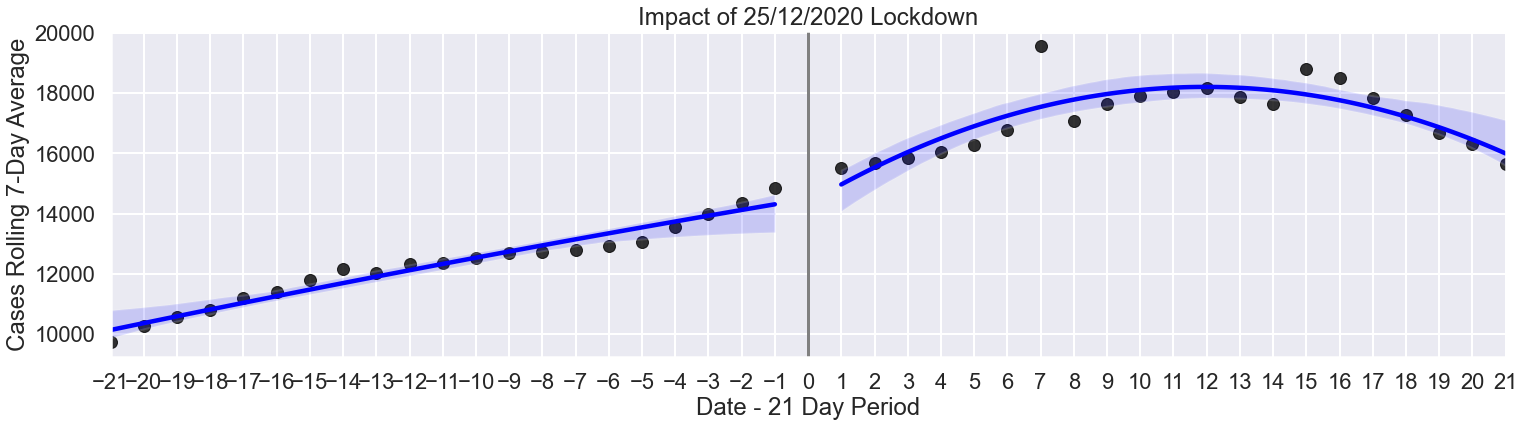

In [36]:
# Create two models for before/after event
beforelock2 = lockdown2[lockdown2['lockdown2_date'] < 0]
afterlock2 = lockdown2[lockdown2['lockdown2_date'] > 0]

# Variable that we need to measure its change
y1 = beforelock2['numtotal_last7']
y2 = afterlock2['numtotal_last7']

# Independent Variable
x1 = beforelock2['lockdown2_date']
x2 = afterlock2['lockdown2_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(25, 6))
ax.set_title('Impact of 25/12/2020 Lockdown')

# Change order to 2
sns.regplot(x = x1, y = y1, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-21,22))
ax.set(xlabel = 'Date - 21 Day Period', ylabel = 'Cases Rolling 7-Day Average')
plt.show()

#### Observations and Findings for 25/12/2020 Lockdown 2:

For this event, we have chosen a period of 3 weeks as after experimenting with shorter and longer period, we found the best model fit within this period. Generally from a pandemic's perspective, we need a 2 week period in order to start seeing positive results of a lockdown which can be clearly observed from the graph above. Comparing the two models for this event, a higher polynomial degree of 2 produces a more fitting graph given our data and period chosen.

During our research of RDD, we found that the method is to measure data just before and just after the threshold. If we have chosen a longer period than 3 weeks, we have might left room for other unknown variables (ie. start of vaccination, curfew, etc.) to affect the model negatively. So choosing 21 days was just enough to show an accurate representation of the effects of this specific event.